In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital.csv', check_param=True, na_values='empty')

INFO:profiler.utility:[4.441799879074097] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': 'empty', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'HospitalName': ['equal'], 'Address1':

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.data.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.data.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.data.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.data.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.data.dataset:updated types of State to 'text'
INFO:profiler.data.dataset:updated operators of State to ['equal']
INFO:profiler.data.dataset:updated types of EmergencyService to 'text'
INFO:profiler.data.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.data.dataset:updated types of Score to 'numeric'
INFO:profiler.data.dataset:updated operators of Score to ['equal']
INFO:profiler.data.dataset:updated types of Sample to 'numeric'
INFO:profiler.data.dataset:updated operators of Sample to ['equal']
INFO:profiler.data.dataset:upd

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
pf.session.load_embedding(save=True, path='data/hospital/', load=True)

INFO:profiler.utility:[6.294607877731323] Load Embedding start

INFO:profiler.utility:[6.35546088218689] Load Embedding execution time: 0.060853004455566406



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [6]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[7.19960880279541] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 165 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 165, and the bound is 0.00007298
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 17/17 [00:00<00:00, 51.54it/s]
INFO:profiler.data.transformer:Number of training samples: 170000
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0296
INFO:profiler.utility:[15.77217984199524] Create Training Data execution time: 8.572571039199829



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [7]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, infer_order=True)

INFO:profiler.utility:[15.786157846450806] Learn Structure start

INFO:profiler.learner:use threshold 0.0481
INFO:profiler.utility:[16.13055992126465] Learn Structure execution time: 0.3444020748138428



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [8]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[18.784701824188232] Get Dependencies start

INFO:profiler.utility:[18.92760181427002] Get Dependencies execution time: 0.1428999900817871



ProviderNumber -> HospitalName (0.04778262564662639)
ProviderNumber,HospitalName -> Address1 (0.03581480009571521)
ProviderNumber,HospitalName,Address1 -> City (0.0519981468488183)
ProviderNumber,HospitalName,Address1,City -> ZipCode (0.03162166007920247)
ProviderNumber,HospitalName,Address1,City,ZipCode -> CountyName (0.05334153792865304)
ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName -> PhoneNumber (0.030615396508314536)
ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber -> HospitalOwner (0.11281126548926404)
MeasureCode -> MeasureName (0.030239926801220677)
MeasureCode,MeasureName -> Stateavg (0.020474711741122968)
MeasureCode,MeasureName,Stateavg -> Condition (0.2041862816783034)
HospitalName,ZipCode,CountyName -> EmergencyService (0.14244596376247692)


In [9]:
import os, json
def read_fds(path='data/fds', f='TECHospital-hyfd'):
    all_fds = {}
    for line in open(os.path.join(path,f)):
        fd = json.loads(line)
        right = fd[u'dependant']['columnIdentifier']
        left = [l[u'columnIdentifier'] for l in fd[ u'determinant'][u'columnIdentifiers']]
        if right not in all_fds:
            all_fds[right] = set()
        all_fds[right].add(frozenset(left))
    return all_fds

In [10]:
gt = read_fds(f='hospital_clean-fun')

In [11]:
tp = 0
count = 0
for child in parent_sets:
    found = parent_sets[child]
    if len(found) == 0:
        continue
    count += 1
    match = False
    for parent in gt[child]:
        if set(parent).issubset(found):
            tp += 1
            match = True
            break
    if not match:
        print("{} -> {} is not valid".format(found, child))
    
print("Precision: %.4f"%(float(tp) / count))

['MeasureCode' 'MeasureName'] -> Stateavg is not valid
Precision: 0.9091


## 5. Visualization

In [12]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

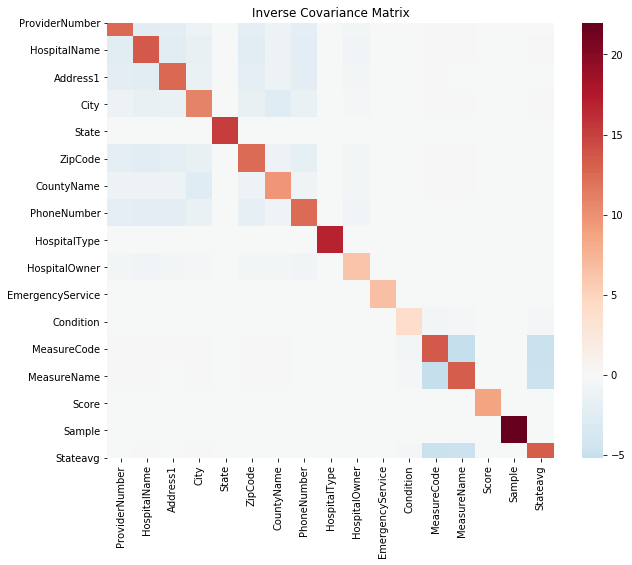

In [13]:
pf.session.visualize_inverse_covariance()

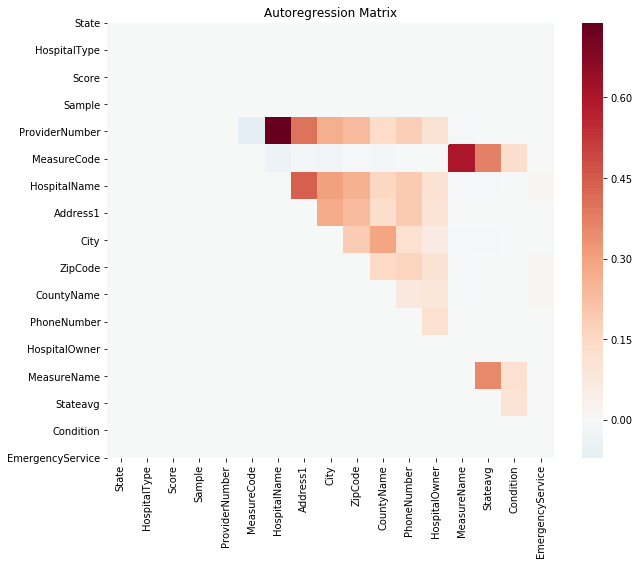

In [14]:
pf.session.visualize_autoregression()

In [15]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,4.441800,start: Load Data,0.000000
1,4.541567,end: Load Data,0.099767
2,6.294608,start: Load Embedding,0.000000
3,6.355461,end: Load Embedding,0.060853
4,7.199609,start: Create Training Data,0.000000
5,15.772180,end: Create Training Data,8.572571
6,15.786158,start: Learn Structure,0.000000
7,16.130560,end: Learn Structure,0.344402
8,18.784702,start: Get Dependencies,0.000000
9,18.927602,end: Get Dependencies,0.142900
